# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [1]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.0
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

## Load the IMFs of the observations

In [2]:
%%time

os.chdir(wrkdir + "/data/")
imfs_sst_ds = xr.open_dataset("imfs_sst.nc")
imfs_mld_ds = xr.open_dataset("imfs_mld.nc")
imfs_oxy200m_ds = xr.open_dataset("imfs_oxy200m.nc")
imfs_oxycline_ds = xr.open_dataset("imfs_oxycline.nc")
imfs_p50_critz_ds = xr.open_dataset("imfs_p50_critz.nc")
imfs_pO2_m_p50_z50_ds = xr.open_dataset("imfs_pO2_m_p50_z50.nc")
imfs_pO2_m_p50_z100_ds = xr.open_dataset("imfs_pO2_m_p50_z100.nc")
imfs_pO2_m_p50_z150_ds = xr.open_dataset("imfs_pO2_m_p50_z150.nc")
imfs_pO2_m_p50_z200_ds = xr.open_dataset("imfs_pO2_m_p50_z200.nc")
imfs_pO2_m_p50_z250_ds = xr.open_dataset("imfs_pO2_m_p50_z250.nc")
imfs_pO2_m_p50_z300_ds = xr.open_dataset("imfs_pO2_m_p50_z300.nc")
imfs_chl_ds = xr.open_dataset("imfs_chl.nc")

sst_trend = imfs_sst_ds['sst_trend']
mld_trend = imfs_mld_ds['mld_trend']
oxy200m_trend = imfs_oxy200m_ds['oxy200m_trend']
oxycline_trend = imfs_oxycline_ds['oxycline_trend']
p50_critz_trend = imfs_p50_critz_ds['p50_critz_trend']
chl_trend = imfs_chl_ds['chl_trend']

sst_imfs = imfs_sst_ds['sst_imfs']
oxy200m_imfs = imfs_oxy200m_ds['oxy200m_imfs']
chl_imfs = imfs_chl_ds['chl_imfs']


CPU times: user 226 ms, sys: 139 ms, total: 365 ms
Wall time: 1.08 s


## Load the precooked correlations and effects of ENSO and IPO

In [3]:
os.chdir(wrkdir + "/data")

enso_sst_ccoef = xr.open_dataset("sst_corr_ENSO_IPO.nc")["sst_corr_enso"]
ipo_sst_ccoef = xr.open_dataset("sst_corr_ENSO_IPO.nc")["sst_corr_ipo"]
enso_sst_effect = xr.open_dataset("sst_effect_ENSO_IPO.nc")["sst_effect_enso"]
ipo_sst_effect = xr.open_dataset("sst_effect_ENSO_IPO.nc")["sst_effect_ipo"]

enso_mld_ccoef = xr.open_dataset("mld_corr_ENSO_IPO.nc")["mld_corr_enso"]
ipo_mld_ccoef = xr.open_dataset("mld_corr_ENSO_IPO.nc")["mld_corr_ipo"]
enso_mld_effect = xr.open_dataset("mld_effect_ENSO_IPO.nc")["mld_effect_enso"]
ipo_mld_effect = xr.open_dataset("mld_effect_ENSO_IPO.nc")["mld_effect_ipo"]

enso_oxy200m_ccoef = xr.open_dataset("oxy200m_corr_ENSO_IPO.nc")["oxy200m_corr_enso"]
ipo_oxy200m_ccoef = xr.open_dataset("oxy200m_corr_ENSO_IPO.nc")["oxy200m_corr_ipo"]
enso_oxy200m_effect = xr.open_dataset("oxy200m_effect_ENSO_IPO.nc")["oxy200m_effect_enso"]
ipo_oxy200m_effect = xr.open_dataset("oxy200m_effect_ENSO_IPO.nc")["oxy200m_effect_ipo"]

enso_oxycline_ccoef = xr.open_dataset("oxycline_corr_ENSO_IPO.nc")["oxycline_corr_enso"]
ipo_oxycline_ccoef = xr.open_dataset("oxycline_corr_ENSO_IPO.nc")["oxycline_corr_ipo"]
enso_oxycline_effect = xr.open_dataset("oxycline_effect_ENSO_IPO.nc")["oxycline_effect_enso"]
ipo_oxycline_effect = xr.open_dataset("oxycline_effect_ENSO_IPO.nc")["oxycline_effect_ipo"]

enso_p50_critz_ccoef = xr.open_dataset("p50_critz_corr_ENSO_IPO.nc")["p50_critz_corr_enso"]
ipo_p50_critz_ccoef = xr.open_dataset("p50_critz_corr_ENSO_IPO.nc")["p50_critz_corr_ipo"]
enso_p50_critz_effect = xr.open_dataset("p50_critz_effect_ENSO_IPO.nc")["p50_critz_effect_enso"]
ipo_p50_critz_effect = xr.open_dataset("p50_critz_effect_ENSO_IPO.nc")["p50_critz_effect_ipo"]

enso_chl_ccoef = xr.open_dataset("chl_corr_ENSO_IPO.nc")["chl_corr_enso"]
ipo_chl_ccoef = xr.open_dataset("chl_corr_ENSO_IPO.nc")["chl_corr_ipo"]
enso_chl_effect = xr.open_dataset("chl_effect_ENSO_IPO.nc")["chl_effect_enso"]
ipo_chl_effect = xr.open_dataset("chl_effect_ENSO_IPO.nc")["chl_effect_ipo"]

enso_p50_critz_ccoef

<xarray.DataArray 'p50_critz_corr_enso' (coef_pval: 2, lat: 145, lon: 360)> Size: 835kB
[104400 values with dtype=float64]
Coordinates:
  * coef_pval  (coef_pval) int64 16B 0 1
  * lat        (lat) float32 580B -64.5 -63.5 -62.5 -61.5 ... 77.5 78.5 79.5
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

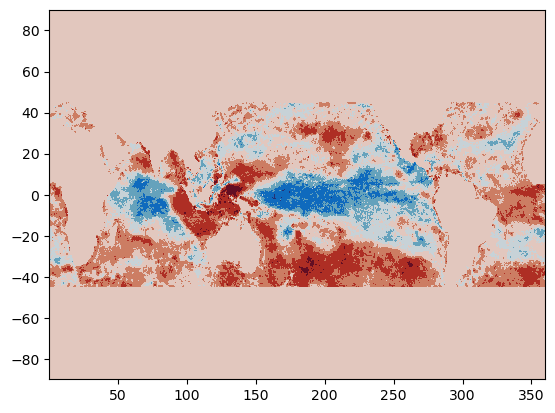

In [4]:
lon_chl = chl_imfs.coords['lon'].values
lat_chl = chl_imfs.coords['lat'].values

plt.figure()
plt.contourf(lon_chl, lat_chl, enso_chl_ccoef[0,:,:]+1e-2, cmap=cmo.balance)


## Define PICTs we are interested in extract values

In [5]:
# Define the approximate latitude and longitude for each location
locations = {
    "Hawaii": [(19.0, -156.0+360.0)],
    "Kiribati": [(3.1, -171.5+360.0)],  # Multiple island groups
    "Nauru": [(-0.5, 166.9)],
    "Solomon Islands": [(-9.6, 161.0)],
    "Guam": [(13.4, 144.7)],
    "Tonga": [(-19.8, -174.8+360.0)]
}



In [6]:
# Extract the data
def extract_correlations(dataar, locations):
    """Extracts time series from a dataset given location coordinates."""
    data = {}
    
    for name, coords in locations.items():
        lat, lon = coords[0]
        
        # Find the closest grid point in the dataset
        ds_sel = dataar.sel(lat=lat, lon=lon, method="nearest")
        
        # Extract correlation
        corr = ds_sel.to_dataframe()
        
        data[name] = corr
        
    return data

# Extract correlations
enso_locations_sst_corrs = extract_correlations(enso_sst_ccoef, locations)
enso_locations_mld_corrs = extract_correlations(enso_mld_ccoef, locations)
enso_locations_oxy200m_corrs = extract_correlations(enso_oxy200m_ccoef, locations)
enso_locations_oxycline_corrs = extract_correlations(enso_oxycline_ccoef, locations)
enso_locations_chl_corrs = extract_correlations(enso_chl_ccoef, locations)

ipo_locations_sst_corrs = extract_correlations(ipo_sst_ccoef, locations)
ipo_locations_mld_corrs = extract_correlations(ipo_mld_ccoef, locations)
ipo_locations_oxy200m_corrs = extract_correlations(ipo_oxy200m_ccoef, locations)
ipo_locations_oxycline_corrs = extract_correlations(ipo_oxycline_ccoef, locations)
ipo_locations_chl_corrs = extract_correlations(ipo_chl_ccoef, locations)



In [7]:
enso_locations_sst_corrs["Hawaii"].iloc[0]

lat               19.000000
lon              204.000000
sst_corr_enso      0.401908
Name: 0, dtype: float64

## Visualise the correlations

CPU times: user 18min 1s, sys: 3.84 s, total: 18min 5s
Wall time: 18min 6s


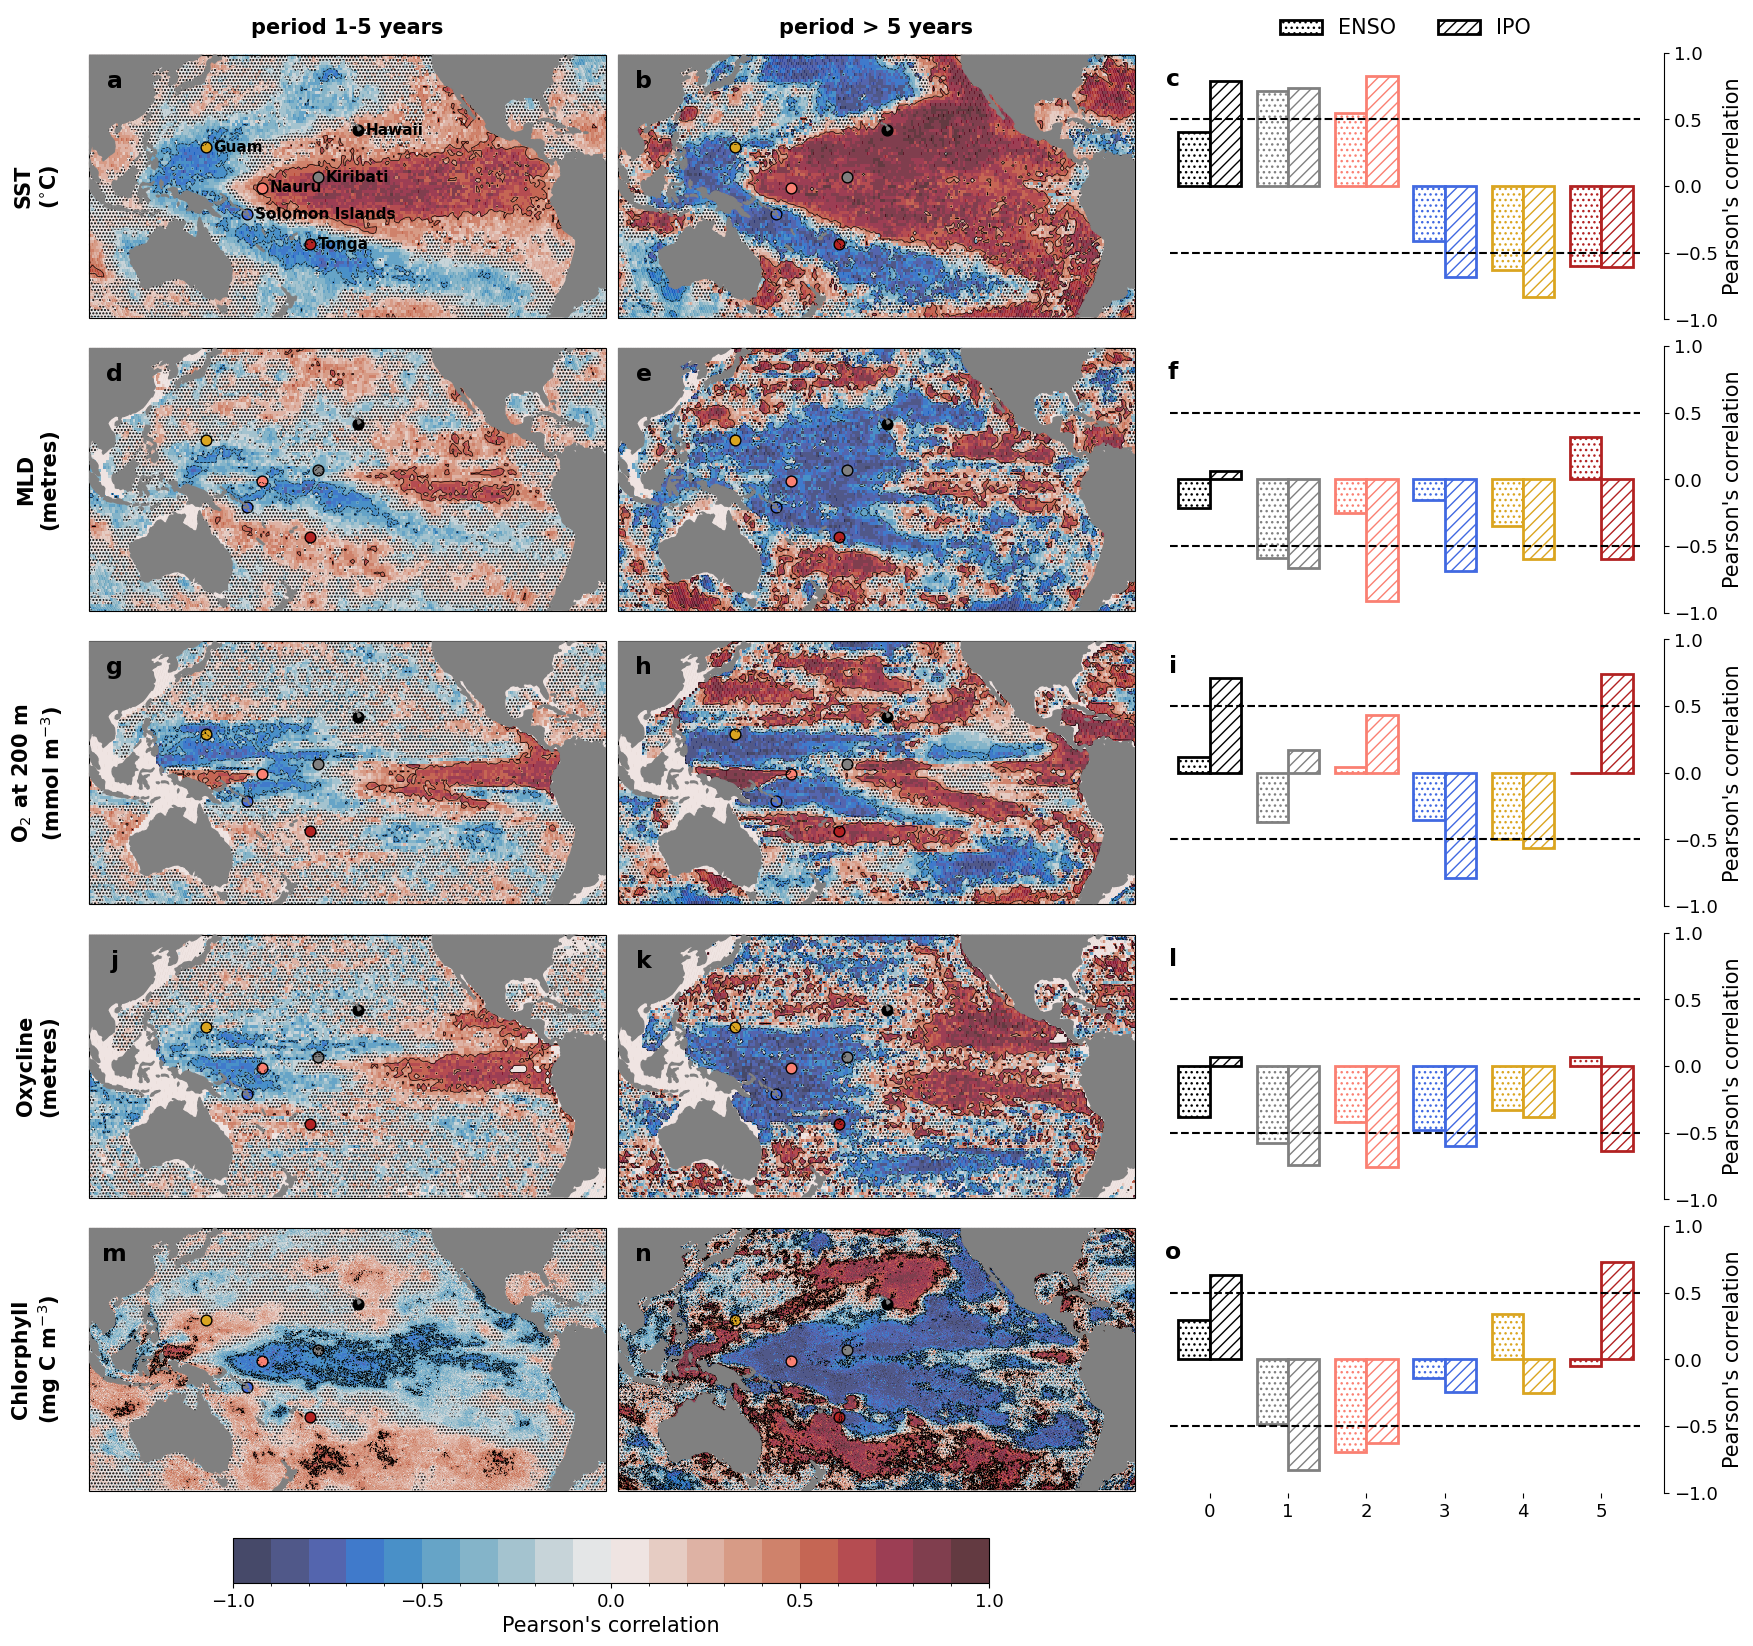

In [10]:
%%time

lon_sst = sst_imfs.coords['lon'].values
lat_sst = sst_imfs.coords['lat'].values
lon_oxy = oxy200m_imfs.coords['lon'].values
lat_oxy = oxy200m_imfs.coords['lat'].values
lon_chl = chl_imfs.coords['lon'].values
lat_chl = chl_imfs.coords['lat'].values

fslab = 15
fstic = 13

proj = ccrs.Robinson(central_longitude=205)

colmap = lighten(cmo.balance, 0.8)
levs = np.arange(-1,1.1,0.1)
norm = mpl.colors.BoundaryNorm(levs, ncolors=256, extend='neither')
contlevs = [-0.5, 0.5]
hatching = [' ', '.....']
hatchlevs = [0.0, 0.05, 1.0]

fig = plt.figure(figsize=(18,18))
gs = GridSpec(5, 12)

ax1 = plt.subplot(gs[0,0:4], projection=proj)
ax2 = plt.subplot(gs[0,4:8], projection=proj)
ax3 = plt.subplot(gs[0,8:12])
ax4 = plt.subplot(gs[1,0:4], projection=proj)
ax5 = plt.subplot(gs[1,4:8], projection=proj)
ax6 = plt.subplot(gs[1,8:12])
ax7 = plt.subplot(gs[2,0:4], projection=proj)
ax8 = plt.subplot(gs[2,4:8], projection=proj)
ax9 = plt.subplot(gs[2,8:12])
ax10 = plt.subplot(gs[3,0:4], projection=proj)
ax11 = plt.subplot(gs[3,4:8], projection=proj)
ax12 = plt.subplot(gs[3,8:12])
ax13 = plt.subplot(gs[4,0:4], projection=proj)
ax14 = plt.subplot(gs[4,4:8], projection=proj)
ax15 = plt.subplot(gs[4,8:12])

p1 = ax1.pcolormesh(lon_sst, lat_sst, enso_sst_ccoef[0,:,:], cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax1.contour(lon_sst, lat_sst, enso_sst_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax1.contourf(lon_sst, lat_sst, enso_sst_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p2 = ax2.pcolormesh(lon_sst, lat_sst, ipo_sst_ccoef[0,:,:], cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax2.contour(lon_sst, lat_sst, ipo_sst_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax2.contourf(lon_sst, lat_sst, ipo_sst_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p4 = ax4.pcolormesh(lon_sst, lat_sst, enso_mld_ccoef[0,:,:], cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax4.contour(lon_sst, lat_sst, enso_mld_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax4.contourf(lon_sst, lat_sst, enso_mld_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p5 = ax5.pcolormesh(lon_sst, lat_sst, ipo_mld_ccoef[0,:,:], cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax5.contour(lon_sst, lat_sst, ipo_mld_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax5.contourf(lon_sst, lat_sst, ipo_mld_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p7 = ax7.pcolormesh(lon_oxy, lat_oxy, enso_oxy200m_ccoef[0,:,:], cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax7.contour(lon_oxy, lat_oxy, enso_oxy200m_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax7.contourf(lon_oxy, lat_oxy, enso_oxy200m_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p8 = ax8.pcolormesh(lon_oxy, lat_oxy, ipo_oxy200m_ccoef[0,:,:], cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax8.contour(lon_oxy, lat_oxy, ipo_oxy200m_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax8.contourf(lon_oxy, lat_oxy, ipo_oxy200m_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p10 = ax10.pcolormesh(lon_oxy, lat_oxy, enso_oxycline_ccoef[0,:,:], cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax10.contour(lon_oxy, lat_oxy, enso_oxycline_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax10.contourf(lon_oxy, lat_oxy, enso_oxycline_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p11 = ax11.pcolormesh(lon_oxy, lat_oxy, ipo_oxycline_ccoef[0,:,:], cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax11.contour(lon_oxy, lat_oxy, ipo_oxycline_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax11.contourf(lon_oxy, lat_oxy, ipo_oxycline_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p13 = ax13.pcolormesh(lon_chl, lat_chl, enso_chl_ccoef[0,:,:], cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax13.contour(lon_chl, lat_chl, enso_chl_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax13.contourf(lon_chl, lat_chl, enso_chl_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p14 = ax14.pcolormesh(lon_chl, lat_chl, ipo_chl_ccoef[0,:,:], cmap=colmap, norm=norm, transform=ccrs.PlateCarree())
ax14.contour(lon_chl, lat_chl, ipo_chl_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax14.contourf(lon_chl, lat_chl, ipo_chl_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

# Add scatter points showing correlations to far right panels
cols = ['k', 'grey', 'salmon', 'royalblue', 'goldenrod', 'firebrick']
hatc = ['...', '///']
ii = 0
for name, coords in locations.items():
    if ii == 0:
        ax3.bar(ii-0.2, enso_locations_sst_corrs[name].iloc[0].values[-1], color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, label="ENSO", width=0.4)
        ax3.bar(ii+0.2, ipo_locations_sst_corrs[name].iloc[0].values[-1], color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, label="IPO", width=0.4)
    else:
        ax3.bar(ii-0.2, enso_locations_sst_corrs[name].iloc[0].values[-1], color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
        ax3.bar(ii+0.2, ipo_locations_sst_corrs[name].iloc[0].values[-1], color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax6.bar(ii-0.2, enso_locations_mld_corrs[name].iloc[0].values[-1], color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax6.bar(ii+0.2, ipo_locations_mld_corrs[name].iloc[0].values[-1], color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax9.bar(ii-0.2, enso_locations_oxy200m_corrs[name].iloc[0].values[-1], color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax9.bar(ii+0.2, ipo_locations_oxy200m_corrs[name].iloc[0].values[-1], color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax12.bar(ii-0.2, enso_locations_oxycline_corrs[name].iloc[0].values[-1], color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax12.bar(ii+0.2, ipo_locations_oxycline_corrs[name].iloc[0].values[-1], color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax15.bar(ii-0.2, enso_locations_chl_corrs[name].iloc[0].values[-1], color='w', hatch=hatc[0], edgecolor=cols[ii], linewidth=2, width=0.4)
    ax15.bar(ii+0.2, ipo_locations_chl_corrs[name].iloc[0].values[-1], color='w', hatch=hatc[1], edgecolor=cols[ii], linewidth=2, width=0.4)
    ii += 1

ii = 0
# Add location points to the map
for name, coords in locations.items():
    lat, lon = coords[0]
    ax1.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax1.text(lon + 3, lat, name, fontsize=fstic-2, transform=ccrs.PlateCarree(), ha='left', va='center', fontweight='bold')
    ax2.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax4.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax5.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax7.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax8.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax10.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax11.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax13.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax14.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ii += 1

ax1.add_feature(cfeature.LAND, color='grey', zorder=3)
ax2.add_feature(cfeature.LAND, color='grey', zorder=3)
ax4.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax10.add_feature(cfeature.LAND, color='grey', zorder=3)
ax11.add_feature(cfeature.LAND, color='grey', zorder=3)
ax13.add_feature(cfeature.LAND, color='grey', zorder=3)
ax14.add_feature(cfeature.LAND, color='grey', zorder=3)

cbax = fig.add_axes([0.13, 0.1, 0.42, 0.025])
cbar = plt.colorbar(p1, cax=cbax, orientation='horizontal', ticks=levs[::5])
cbar.ax.set_xlabel("Pearson's correlation", fontsize=fslab)
cbar.ax.tick_params(labelsize=fstic)

xx = -0.1; yy = 0.5
plt.text(xx, yy, 'SST\n($^{\circ}$C)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax1.transAxes)
plt.text(xx, yy, 'MLD\n(metres)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax4.transAxes)
plt.text(xx, yy, 'O$_2$ at 200 m\n(mmol m$^{-3}$)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax7.transAxes)
plt.text(xx, yy, 'Oxycline\n(metres)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax10.transAxes)
#plt.text(xx, yy, 'Skipjack O$^{crit}_2$\n(metres)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax9.transAxes)
plt.text(xx, yy, 'Chlorphyll\n(mg C m$^{-3}$)', ha='center', va='center', fontsize=fslab, fontweight='bold', rotation=90, transform=ax13.transAxes)

ax1.text(0.5, 1.1, 'period 1-5 years', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax1.transAxes)
ax2.text(0.5, 1.1, 'period > 5 years', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax2.transAxes)

lon1 = 100; lon2 = 300
lat1 = -45; lat2 = 45
ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax2.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax4.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax5.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax7.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax8.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax10.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax11.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax13.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax14.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())

xx = 0.05; yy = 0.9
plt.text(xx, yy, "a", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax1.transAxes)
plt.text(xx, yy, "b", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax2.transAxes)
plt.text(xx, yy, "c", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax3.transAxes)
plt.text(xx, yy, "d", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax4.transAxes)
plt.text(xx, yy, "e", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax5.transAxes)
plt.text(xx, yy, "f", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax6.transAxes)
plt.text(xx, yy, "g", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax7.transAxes)
plt.text(xx, yy, "h", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax8.transAxes)
plt.text(xx, yy, "i", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax9.transAxes)
plt.text(xx, yy, "j", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax10.transAxes)
plt.text(xx, yy, "k", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax11.transAxes)
plt.text(xx, yy, "l", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax12.transAxes)
plt.text(xx, yy, "m", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax13.transAxes)
plt.text(xx, yy, "n", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax14.transAxes)
plt.text(xx, yy, "o", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax15.transAxes)

ax3.spines[['top', 'left', 'bottom']].set_visible(False)
ax6.spines[['top', 'left', 'bottom']].set_visible(False)
ax9.spines[['top', 'left', 'bottom']].set_visible(False)
ax12.spines[['top', 'left', 'bottom']].set_visible(False)
ax15.spines[['top', 'left', 'bottom']].set_visible(False)

ax3.tick_params(labelsize=fstic, bottom=False, labelbottom=False, left=False, labelleft=False, right=True, labelright=True)
ax6.tick_params(labelsize=fstic, bottom=False, labelbottom=False, left=False, labelleft=False, right=True, labelright=True)
ax9.tick_params(labelsize=fstic, bottom=False, labelbottom=False, left=False, labelleft=False, right=True, labelright=True)
ax12.tick_params(labelsize=fstic, bottom=False, labelbottom=False, left=False, labelleft=False, right=True, labelright=True)
ax15.tick_params(labelsize=fstic, left=False, labelleft=False, right=True, labelright=True)

ax3.set_ylim(-1,1)
ax6.set_ylim(-1,1)
ax9.set_ylim(-1,1)
ax12.set_ylim(-1,1)
ax15.set_ylim(-1,1)

ax3.set_ylabel("Pearson's correlation", fontsize=fslab)
ax6.set_ylabel("Pearson's correlation", fontsize=fslab)
ax9.set_ylabel("Pearson's correlation", fontsize=fslab)
ax12.set_ylabel("Pearson's correlation", fontsize=fslab)
ax15.set_ylabel("Pearson's correlation", fontsize=fslab)

ax3.yaxis.set_label_position('right')
ax6.yaxis.set_label_position('right')
ax9.yaxis.set_label_position('right')
ax12.yaxis.set_label_position('right')
ax15.yaxis.set_label_position('right')

ax3.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax3.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')
ax6.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax6.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')
ax9.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax9.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')
ax12.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax12.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')
ax15.plot((-0.5, 5.5),(0.5, 0.5), 'k--')
ax15.plot((-0.5, 5.5),(-0.5, -0.5), 'k--')


ax3.legend(frameon=False, loc='upper center', ncols=2, fontsize=fslab, bbox_to_anchor=(0.5,1.2))

plt.subplots_adjust(top=0.95, right=0.925, left=0.05, wspace=0.1, hspace=0.1, bottom=0.15)



In [9]:
os.chdir(wrkdir)
fig.savefig("./figures/obs_decomposition_correlations_zoompacific.png", dpi=300)
fig.savefig("./figures/obs_decomposition_correlations_zoompacific_transparent.png", dpi=300, transparent=True)
